<a href="https://colab.research.google.com/github/rsanchezgarc/AI-ML-analytics-IE/blob/main/notebooks/contrastive/Triplet_loss_and_few_shot_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Contrastive Learning with Triplet Loss

In this notebook we will:
1. Load and preprocess CIFAR-10/100 data.
2. Define a custom `TripletDataset` that generates (anchor, positive, negative) triplets.
3. Implement a CNN embedding network and the triplet loss.
4. Split the CIFAR-10 training set into training and validation subsets.
5. Train the model using the triplet loss while monitoring validation loss.
6. Evaluate the learned embeddings via few-shot classification.
7. (TODO) Experiment with triplet mining strategies (e.g., hard negative mining).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
import torchvision
import torchvision.transforms as transforms
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from tqdm.notebook import tqdm

# Set device for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


## 1. Data Loading and Preprocessing

We use CIFAR-10 for training the embedding network (and later monitoring validation loss)
and CIFAR-100 for few-shot evaluation.

In [ ]:
# Define transforms for training and testing
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load CIFAR-10 for training
full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform_train)

# Load CIFAR-100 for few-shot evaluation
cifar100 = torchvision.datasets.CIFAR100(root='./data', train=False,
                                         download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


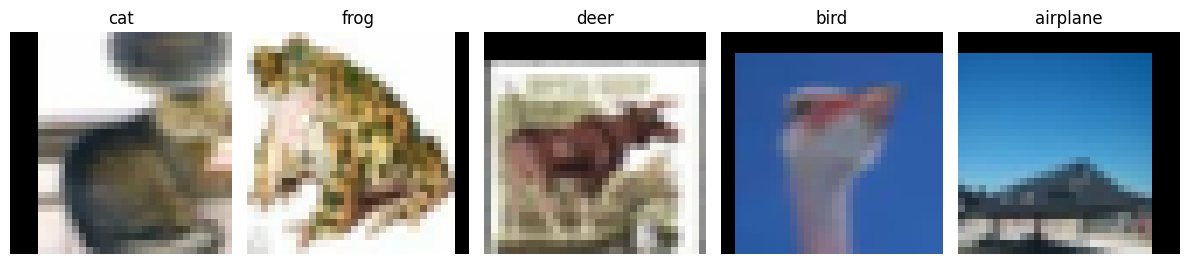

In [ ]:
# Function to show some sample images
def show_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(12, 3))
    for i in range(num_images):
        idx = random.randint(0, len(dataset)-1)
        img, label = dataset[idx]
        img = img.numpy().transpose((1, 2, 0))
        # Denormalize image for visualization
        mean = np.array([0.4914, 0.4822, 0.4465])
        std = np.array([0.2023, 0.1994, 0.2010])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        axes[i].imshow(img)
        if hasattr(dataset, 'classes'):
            title = dataset.classes[label]
        else:
            title = f"Class {label}"
        axes[i].set_title(title)
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# Show some images from the full training set
show_images(full_trainset)

## 2. Creating a Train/Validation Split

We split the CIFAR-10 training set into a training subset and a validation subset.
Both subsets will be wrapped in the custom `TripletDataset` class.

In [ ]:
# Split the CIFAR-10 training set: 80% for training and 20% for validation
train_size = int(0.8 * len(full_trainset))
val_size = len(full_trainset) - train_size
train_subset, val_subset = random_split(full_trainset, [train_size, val_size])
print(f"Train subset size: {len(train_subset)}, Validation subset size: {len(val_subset)}")

Train subset size: 40000, Validation subset size: 10000


## 3. Triplet Dataset Class

This custom Dataset generates (anchor, positive, negative) triplets.  
It randomly selects a positive example (another sample of the same class) and a negative example (from a different class).

**TODO for Students:**  
- Modify the `__getitem__` method to implement a triplet mining strategy (e.g., hard or semi-hard negative mining).

In [ ]:
class TripletDataset(Dataset):
    def __init__(self, base_dataset, transform=None):
        """
        Args:
            base_dataset: A dataset returning (image, label)
            transform: Optional transform to apply to images (if not already applied)
        """
        self.dataset = base_dataset
        self.transform = transform
        self.class_to_indices = self._create_class_indices()

    def _create_class_indices(self):
        class_to_idx = {}
        for idx, (_, label) in enumerate(self.dataset):
            if label not in class_to_idx:
                class_to_idx[label] = []
            class_to_idx[label].append(idx)
        return class_to_idx

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Get anchor
        anchor_img, anchor_label = self.dataset[idx]
        if self.transform:
            anchor_img = self.transform(anchor_img)

        # Select positive sample (different index but same class)
        pos_idx = idx
        while pos_idx == idx:
            pos_idx = random.choice(self.class_to_indices[anchor_label])
        positive_img, _ = self.dataset[pos_idx]
        if self.transform:
            positive_img = self.transform(positive_img)

        # Select negative sample (from a different class)
        neg_label = anchor_label
        while neg_label == anchor_label:
            neg_label = random.choice(list(self.class_to_indices.keys()))
        neg_idx = random.choice(self.class_to_indices[neg_label])
        negative_img, _ = self.dataset[neg_idx]
        if self.transform:
            negative_img = self.transform(negative_img)

        # Return the triplet and the anchor label (for potential monitoring)
        return anchor_img, positive_img, negative_img, anchor_label

# Create triplet datasets for training and validation
triplet_train_dataset = TripletDataset(train_subset, transform=None)  # transforms already applied
triplet_val_dataset   = TripletDataset(val_subset, transform=None)

# DataLoaders for training and validation
triplet_train_loader = DataLoader(triplet_train_dataset, batch_size=128, shuffle=True, num_workers=2)
triplet_val_loader   = DataLoader(triplet_val_dataset, batch_size=128, shuffle=False, num_workers=2)

## 4. Model and Loss Function

We define a simple CNN-based embedding network and the triplet loss.  
Note that the custom triplet loss now computes the Euclidean distances (L2 norm) to match PyTorch’s built-in implementation.

In [ ]:
class EmbeddingNet(nn.Module):
    def __init__(self, embedding_dim=128):
        super(EmbeddingNet, self).__init__()
        # A simple CNN with three conv layers followed by two fully connected layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 8 * 8, 512)  # Feature map size after two stride-2 conv layers
        self.fc2 = nn.Linear(512, embedding_dim)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        # L2 normalization of embeddings
        x = F.normalize(x, p=2, dim=1)
        return x

class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        # Compute L2 distances between anchor-positive and anchor-negative
        d_pos = NotImplemented
        d_neg = NotImplemented
        losses = NotImplemented
        return NotImplemented

### Testing the Triplet Loss Implementation

We compare our custom `TripletLoss` with PyTorch’s built-in `TripletMarginLoss` as an oracle.

In [ ]:
def test_triplet_loss():
    margin = 0.5
    # Define a simple test case
    anchor = torch.randn(32, 128, device=device)
    positive = torch.randn(32, 128, device=device)
    negative = torch.randn(32, 128, device=device)

    custom_loss_fn = TripletLoss(margin=margin)
    oracle_loss_fn = nn.TripletMarginLoss(margin=margin, p=2, reduction='mean')

    custom_loss = custom_loss_fn(anchor, positive, negative)
    oracle_loss = oracle_loss_fn(anchor, positive, negative)

    print(f"Custom triplet loss: {custom_loss.item():.6f}")
    print(f"Oracle (PyTorch) loss: {oracle_loss.item():.6f}")
    assert abs(custom_loss.item() - oracle_loss.item()) < 1e-6, "Triplet loss implementation error!"
    print("Triplet loss implementation is correct!")

test_triplet_loss()

Custom triplet loss: 1.085061
Oracle (PyTorch) loss: 1.085061
Triplet loss implementation is correct!


## 5. Training Loop

We train the embedding network using the triplet dataset for training while also monitoring the
validation loss on the held-out validation set.
    
**TODO for Students:**  
- Replace the simple random negative selection (in the TripletDataset) with a triplet mining strategy
  (e.g., hard negative or semi-hard negative mining) to see if performance improves.

Epoch 1/15 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1 - Train Loss: 0.7132, Val Loss: 0.6595


Epoch 2/15 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 0.6371, Val Loss: 0.5945


Epoch 3/15 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3 - Train Loss: 0.6025, Val Loss: 0.5786


Epoch 4/15 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4 - Train Loss: 0.5655, Val Loss: 0.5597


Epoch 5/15 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.5477, Val Loss: 0.5171


Epoch 6/15 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 6 - Train Loss: 0.5140, Val Loss: 0.5036


Epoch 7/15 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 7 - Train Loss: 0.4927, Val Loss: 0.4953


Epoch 8/15 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 8 - Train Loss: 0.4748, Val Loss: 0.4683


Epoch 9/15 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 9 - Train Loss: 0.4599, Val Loss: 0.4559


Epoch 10/15 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 10 - Train Loss: 0.4544, Val Loss: 0.4697


Epoch 11/15 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 11 - Train Loss: 0.4363, Val Loss: 0.4566


Epoch 12/15 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 12 - Train Loss: 0.4236, Val Loss: 0.4366


Epoch 13/15 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 13 - Train Loss: 0.4192, Val Loss: 0.4308


Epoch 14/15 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 14 - Train Loss: 0.4055, Val Loss: 0.4103


Epoch 15/15 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 15 - Train Loss: 0.3994, Val Loss: 0.4170


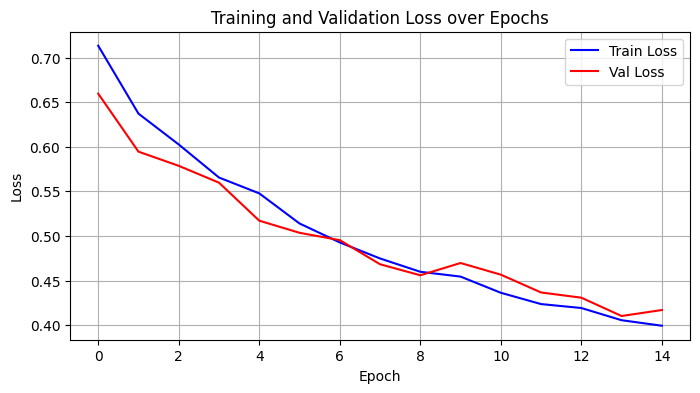

In [ ]:
def compute_validation_loss(model, val_loader, margin=1.0):
    model.eval()
    criterion = TripletLoss(margin=margin)
    total_loss = 0.0
    count = 0
    with torch.no_grad():
        for anchor, positive, negative, _ in val_loader:
            anchor = anchor.to(device)
            positive = positive.to(device)
            negative = negative.to(device)
            # Compute embeddings and loss
            loss = criterion(model(anchor), model(positive), model(negative))
            total_loss += loss.item()
            count += 1
    return total_loss / count if count > 0 else 0

def train_model(model, train_loader, val_loader, epochs=5, margin=1.0):
    model.train()
    criterion = TripletLoss(margin=margin)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_losses = []
    val_losses = []

    best_avg_val_loss = 9999999.
    n_epochs_no_improvement = 0
    for epoch in range(epochs):
        running_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")
        for anchor, positive, negative, _ in progress_bar:
            anchor = anchor.to(device)
            positive = positive.to(device)
            negative = negative.to(device)

            # Forward pass: compute embeddings and loss
            anchor_emb = model(anchor)
            positive_emb = model(positive)
            negative_emb = model(negative)
            loss = criterion(anchor_emb, positive_emb, negative_emb)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Compute validation loss
        avg_val_loss = compute_validation_loss(model, val_loader, margin=margin)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        if avg_val_loss > best_avg_val_loss: #if it has not improved in the last epoch
            #Early stop
            n_epochs_no_improvement += 1
        else:
            best_avg_val_loss = float(avg_val_loss)
            n_epochs_no_improvement = 0
        if n_epochs_no_improvement > 2:
            break
    # Plot training and validation loss curves
    plt.figure(figsize=(8, 4))
    plt.plot(train_losses, 'b-', label='Train Loss')
    plt.plot(val_losses, 'r-', label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model

# Instantiate and train the model using the TripletDataset
embedding_dim = 64
model = EmbeddingNet(embedding_dim=embedding_dim).to(device)
#Let it train for a few more epochs to get better performance
model = train_model(model, triplet_train_loader, triplet_val_loader, epochs=15, margin=1.0)

## 6. Few-Shot Evaluation on CIFAR-100

We use the learned embeddings for a few-shot classification task on CIFAR-100.

Few-shot task: 10 classes, 5-shot
Training set: 50 images, Test set: 950 images
Selected classes: ['castle', 'sweet_pepper', 'oak_tree', 'rabbit', 'hamster', 'willow_tree', 'leopard', 'trout', 'squirrel', 'camel']
Random baseline accuracy: 10.00%


Extracting features:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting features:   0%|          | 0/15 [00:00<?, ?it/s]

3-NN 5-shot accuracy: 22.21%


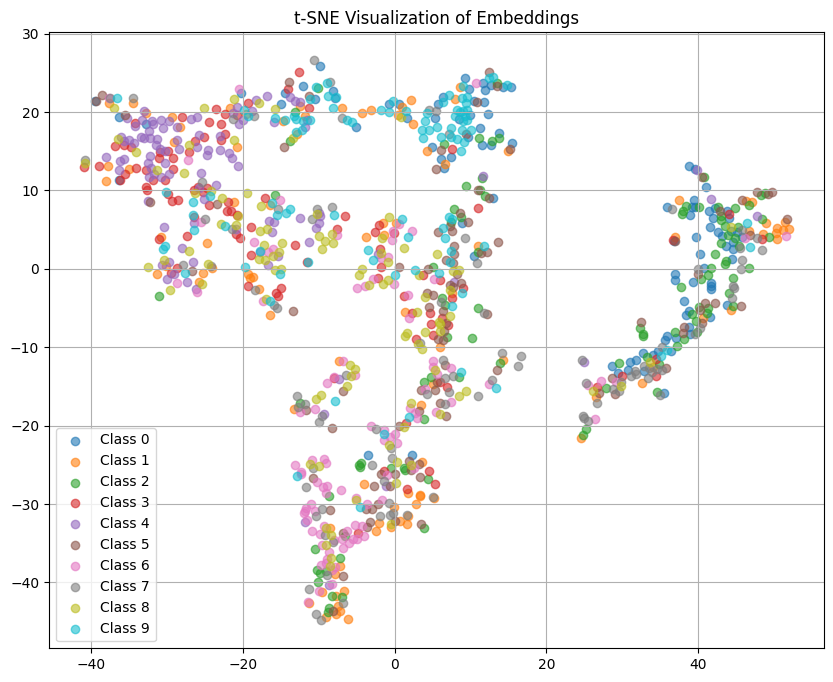

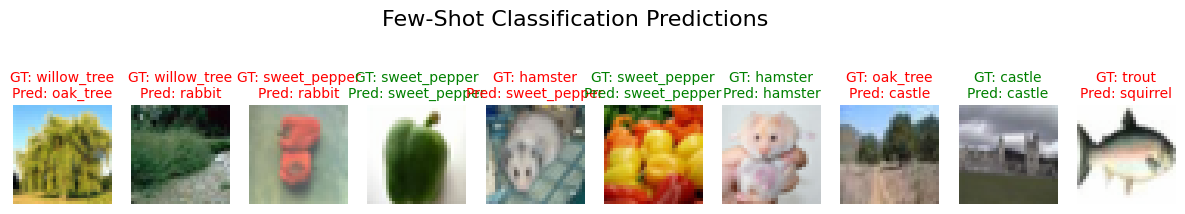

In [ ]:
def extract_features(model, dataloader):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for images, batch_labels in tqdm(dataloader, desc="Extracting features"):
            images = images.to(device)
            outputs = model(images)
            features.append(outputs.cpu())
            labels.append(batch_labels)
    return torch.cat(features), torch.cat(labels)

def prepare_few_shot_data(cifar100, num_classes=10, k_shot=5):
    all_classes = list(range(100))
    selected_classes = random.sample(all_classes, num_classes)
    class_mapping = {cls: i for i, cls in enumerate(selected_classes)}

    train_images, train_labels = [], []
    test_images, test_labels = [], []
    for img, label in cifar100:
        if label in selected_classes:
            new_label = class_mapping[label]
            # Count how many samples for training already exist for this class
            if train_labels.count(new_label) < k_shot:
                train_images.append(img)
                train_labels.append(new_label)
            else:
                test_images.append(img)
                test_labels.append(new_label)

    train_images = torch.stack(train_images)
    train_labels = torch.tensor(train_labels)
    test_images = torch.stack(test_images)
    test_labels = torch.tensor(test_labels)

    return train_images, train_labels, test_images, test_labels, selected_classes

def few_shot_evaluation(model, cifar100, num_classes=10, k_shot=5,
                        num_examples_to_plot=10, n_neighbors=1):
    # Prepare few-shot data
    train_images, train_labels, test_images, test_labels, selected_classes = prepare_few_shot_data(cifar100, num_classes, k_shot)
    print(f"Few-shot task: {num_classes} classes, {k_shot}-shot")
    print(f"Training set: {len(train_images)} images, Test set: {len(test_images)} images")

    # Create a mapping from new labels to actual CIFAR-100 class names
    new_class_names = {i: cifar100.classes[selected_classes[i]] for i in range(num_classes)}
    print("Selected classes:", list(new_class_names.values()))

    # Random baseline (chance level for balanced classes)
    random_baseline = 100.0 / num_classes
    print(f"Random baseline accuracy: {random_baseline:.2f}%")

    # Extract embeddings using the model
    train_loader = DataLoader(TensorDataset(train_images, train_labels), batch_size=64, shuffle=False)
    test_loader = DataLoader(TensorDataset(test_images, test_labels), batch_size=64, shuffle=False)
    train_features, _ = extract_features(model, train_loader)
    test_features, _ = extract_features(model, test_loader)

    # K-nearest neighbors classification with tunable n_neighbors
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(train_features.numpy(), train_labels.numpy())
    predictions = knn.predict(test_features.numpy())
    accuracy = np.mean(predictions == test_labels.numpy()) * 100
    print(f"{n_neighbors}-NN {k_shot}-shot accuracy: {accuracy:.2f}%")

    # t-SNE visualization of embeddings
    tsne = TSNE(n_components=2, random_state=42)
    all_features = torch.cat([train_features, test_features], dim=0)
    all_labels = torch.cat([train_labels, test_labels], dim=0)
    embedded = tsne.fit_transform(all_features.numpy())

    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        mask = (all_labels == i).numpy()
        plt.scatter(embedded[mask, 0], embedded[mask, 1], alpha=0.6, label=f"Class {i}")
    plt.title('t-SNE Visualization of Embeddings')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot a few test examples with predicted vs ground-truth labels.
    num_examples_to_plot = min(num_examples_to_plot, len(test_images))
    indices = random.sample(range(len(test_images)), num_examples_to_plot)
    # Denormalization parameters for CIFAR-100 (same as CIFAR-10 in this context)
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])

    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(indices):
        img = test_images[idx]
        # Denormalize the image
        img = img.cpu().numpy().transpose((1, 2, 0))
        img = std * img + mean
        img = np.clip(img, 0, 1)

        gt_label = test_labels[idx].item()
        pred_label = predictions[idx]
        gt_class = new_class_names[gt_label]
        pred_class = new_class_names[pred_label]
        title_color = 'green' if gt_label == pred_label else 'red'

        plt.subplot(1, num_examples_to_plot, i+1)
        plt.imshow(img)
        plt.title(f"GT: {gt_class}\nPred: {pred_class}", color=title_color, fontsize=10)
        plt.axis('off')
    plt.suptitle('Few-Shot Classification Predictions', fontsize=16)
    plt.show()

    return accuracy


# Run few-shot evaluation on CIFAR-100 (e.g., 10 classes, 5-shot)
few_shot_accuracy = few_shot_evaluation(model, cifar100, num_classes=10, k_shot=5,
                        num_examples_to_plot=10, n_neighbors=3)

"""
## 7. Conclusion and Further Exploration

In this notebook we:
- Created a train/validation split and a custom `TripletDataset` to generate triplets.
- Built a CNN embedding network and implemented a custom triplet loss that matches PyTorch’s built-in version.
- Monitored both training and validation losses during training.
- Evaluated the learned embeddings on a few-shot classification task.

**Further Exercises:**
1. **Triplet Mining:**  
   * TODO: Modify the `TripletDataset` or training loop to implement hard or semi-hard negative mining.
2. **Architecture Tuning:**  
   * Experiment with different embedding dimensions or network architectures.
   * What is the minimal number of examples of each class that need to be added to the support set to achieve good performance?
3. **Experimentation:**
   * Try to use feature extraction with a pre-trained ResNet instead of the contrastive model and compare performance.
   * Compare how different mining strategies impact the validation loss and few-shot accuracy.


## 8. (Optional): SimCLR

### 1. Data Augmentations for SimCLR

SimCLR relies on strong data augmentations to create two different views of the same image.
Below we define a transformation pipeline using random cropping, horizontal flipping, color jitter,
and Gaussian blur.

In [ ]:
import torchvision.transforms.v2 as T

# Define a strong augmentation pipeline for SimCLR
simclr_transform = T.Compose([
    T.RandomResizedCrop(size=32, scale=(0.2, 1.0)),
    T.RandomHorizontalFlip(),
    T.ColorJitter(0.4, 0.4, 0.4, 0.1),
    T.RandomGrayscale(p=0.2),
    T.GaussianBlur(kernel_size=3),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


### 2. Dual-View Dataset for SimCLR

This dataset wraps an existing dataset and returns two different augmented views
of the same image.

In [ ]:
class SimCLRDualViewDataset(Dataset):
    """
    A dataset wrapper that returns two augmented views of the same image for SimCLR training.

    Args:
        base_dataset (Dataset): Base dataset returning (image, label).
        transform (callable): Data augmentation transform.
    """
    def __init__(self, base_dataset, transform):
        self.base_dataset = base_dataset
        self.transform = transform

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        img, label = self.base_dataset[idx]
        view1 = self.transform(img)
        view2 = self.transform(img)
        return view1, view2, label  # Optionally return label for monitoring

### 3. SimCLR Model with Projection Head

We use the same backbone as before (a simple CNN) and add a projection head (MLP)
that maps the embeddings to a space where the contrastive loss is applied.

In [ ]:
class SimCLRModel(nn.Module):
    def __init__(self, embedding_dim=64, projection_dim=32):
        """
        SimCLR model consisting of a backbone and a projection head.

        Args:
            embedding_dim (int): Dimensionality of the backbone embeddings.
            projection_dim (int): Dimensionality of the projection head output.
        """
        super(SimCLRModel, self).__init__()
        # Use the same backbone as in the triplet loss experiment
        self.backbone = EmbeddingNet(embedding_dim=embedding_dim)
        # Projection head: a simple MLP with one hidden layer
        self.projection_head = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim),
            nn.ReLU(),
            nn.Linear(embedding_dim, projection_dim)
        )

    def forward(self, x):
        """
        Forward pass returns both the backbone embedding and the projection.

        Args:
            x (Tensor): Input image batch.

        Returns:
            embedding (Tensor): Backbone features (normalized).
            projection (Tensor): Projected features used for contrastive loss.
        """
        embedding = self.backbone(x)
        projection = self.projection_head(embedding)
        # Normalize projection vectors
        projection = F.normalize(projection, p=2, dim=1)
        return embedding, projection

### 4. NT-Xent Loss

The NT-Xent loss compares pairs of projections from the two augmented views.

In [ ]:
def nt_xent_loss(z1, z2, temperature=0.5):
    """
    Compute the NT-Xent (Normalized Temperature-scaled Cross Entropy) loss.

    Args:
        z1 (Tensor): Projections from view 1 of shape (batch_size, projection_dim).
        z2 (Tensor): Projections from view 2 of shape (batch_size, projection_dim).
        temperature (float): Temperature scaling parameter.

    Returns:
        loss (Tensor): Scalar loss.
    """
    batch_size = z1.shape[0]
    z = torch.cat([z1, z2], dim=0)  # (2*batch_size, projection_dim)

    # Compute cosine similarity matrix
    sim_matrix = F.cosine_similarity(z.unsqueeze(1), z.unsqueeze(0), dim=2)
    # Scale by temperature
    sim_matrix = sim_matrix / temperature

    # Create labels: positive pair for i is i + batch_size for i in first half, vice versa.
    labels = torch.arange(batch_size, device=z.device)
    labels = torch.cat([labels + batch_size, labels], dim=0)

    # Mask out similarity between same views (diagonal)
    mask = torch.eye(2 * batch_size, device=z.device).bool()
    sim_matrix.masked_fill_(mask, -9e15)

    # Compute cross-entropy loss
    loss = F.cross_entropy(sim_matrix, labels)
    return loss


### 5. Training Loop for SimCLR

This cell trains the SimCLR model using the NT-Xent loss.
Each batch produces two augmented views, and the loss is computed between the projections.

In [ ]:
def compute_simclr_val_loss(model, val_loader, temperature=0.5):
    """
    Compute the validation loss for SimCLR using the NT-Xent loss.

    Args:
        model (nn.Module): The SimCLR model.
        val_loader (DataLoader): DataLoader yielding pairs of augmented views.
        temperature (float): Temperature parameter for the NT-Xent loss.

    Returns:
        float: The average validation loss.
    """
    model.eval()
    total_loss = 0.0
    count = 0
    with torch.no_grad():
        for view1, view2, _ in val_loader:
            view1 = view1.to(device)
            view2 = view2.to(device)
            _, z1 = model(view1)
            _, z2 = model(view2)
            loss = nt_xent_loss(z1, z2, temperature=temperature)
            total_loss += loss.item()
            count += 1
    return total_loss / count if count > 0 else 0

def train_simclr(model, train_loader, val_loader=None, epochs=10, temperature=0.5, early_stop_patience=2):
    """
    Train the SimCLR model using NT-Xent loss, reporting both training and validation loss,
    and implement early stopping if the validation loss does not improve for more than a given number of epochs.

    Args:
        model (nn.Module): The SimCLR model.
        train_loader (DataLoader): DataLoader yielding pairs of augmented views for training.
        val_loader (DataLoader, optional): DataLoader yielding pairs of augmented views for validation.
                                           If provided, validation loss is computed each epoch.
        epochs (int): Maximum number of training epochs.
        temperature (float): Temperature parameter for the NT-Xent loss.
        early_stop_patience (int): Number of epochs with no improvement in validation loss before stopping early.

    Returns:
        tuple: (model, train_loss_history, val_loss_history)
            model (nn.Module): The trained SimCLR model.
            train_loss_history (list): List of average training losses per epoch.
            val_loss_history (list): List of average validation losses per epoch (empty if val_loader is None).
    """
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_loss_history = []
    val_loss_history = [] if val_loader is not None else None
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f"SimCLR Epoch {epoch+1}/{epochs}")

        for view1, view2, _ in progress_bar:
            view1 = view1.to(device)
            view2 = view2.to(device)

            # Forward pass: get projections for both views
            _, z1 = model(view1)
            _, z2 = model(view2)
            loss = nt_xent_loss(z1, z2, temperature=temperature)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())

        avg_train_loss = running_loss / len(train_loader)
        train_loss_history.append(avg_train_loss)
        print(f"Epoch {epoch+1}: Training Loss = {avg_train_loss:.4f}")

        if val_loader is not None:
            val_loss = compute_simclr_val_loss(model, val_loader, temperature=temperature)
            val_loss_history.append(val_loss)
            print(f"Epoch {epoch+1}: Validation Loss = {val_loss:.4f}")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1

            if epochs_without_improvement > early_stop_patience:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                break

    # Plot training and validation loss curves if validation data is provided
    plt.figure(figsize=(8, 4))
    plt.plot(train_loss_history, 'b-', label='Training Loss')
    if val_loader is not None:
        plt.plot(val_loss_history, 'r-', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('SimCLR Training and Validation Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model, train_loss_history, val_loss_history

# Create a dual-view dataset using CIFAR-10 training data
simclr_train_dataset = SimCLRDualViewDataset(train_subset, transform=simclr_transform)
simclr_train_loader = DataLoader(simclr_train_dataset, batch_size=256, shuffle=True, num_workers=2)

simclr_val_dataset = SimCLRDualViewDataset(val_subset, transform=simclr_transform)
simclr_val_loader = DataLoader(simclr_val_dataset, batch_size=256, shuffle=True, num_workers=2)


# Instantiate and train the SimCLR model
simclr_model = SimCLRModel(embedding_dim=64, projection_dim=32).to(device)
simclr_model, simclr_loss_history, val_loss_history = train_simclr(simclr_model, simclr_train_loader, simclr_val_loader, epochs=10, temperature=0.5)

SimCLR Epoch 1/10:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 1: Training Loss = 5.2736
Epoch 1: Validation Loss = 5.1040


SimCLR Epoch 2/10:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2: Training Loss = 5.1333
Epoch 2: Validation Loss = 5.0907


SimCLR Epoch 3/10:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3: Training Loss = 5.0867
Epoch 3: Validation Loss = 5.0284


SimCLR Epoch 4/10:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4: Training Loss = 5.0532
Epoch 4: Validation Loss = 5.0042


SimCLR Epoch 5/10:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5: Training Loss = 5.0346
Epoch 5: Validation Loss = 4.9818


SimCLR Epoch 6/10:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 6: Training Loss = 5.0175
Epoch 6: Validation Loss = 4.9669


SimCLR Epoch 7/10:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 7: Training Loss = 5.0090
Epoch 7: Validation Loss = 4.9864


SimCLR Epoch 8/10:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 8: Training Loss = 5.0009
Epoch 8: Validation Loss = 5.0406


SimCLR Epoch 9/10:   0%|          | 0/157 [00:00<?, ?it/s]

### 6. Evaluating SimCLR Representations on Few-Shot Classification

After SimCLR training, we discard the projection head and use the backbone's output
as the image embedding. We then evaluate these embeddings using the same few-shot
evaluation procedure defined earlier.

Few-shot task (SimCLR): 10 classes, 5-shot
Training set: 50 images, Test set: 950 images
Selected classes: ['tractor', 'pine_tree', 'sunflower', 'pickup_truck', 'bee', 'dinosaur', 'rose', 'otter', 'crocodile', 'willow_tree']
Random baseline accuracy: 10.00%


Extracting Backbone Features:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting Backbone Features:   0%|          | 0/15 [00:00<?, ?it/s]

1-NN 5-shot accuracy (SimCLR): 22.42%


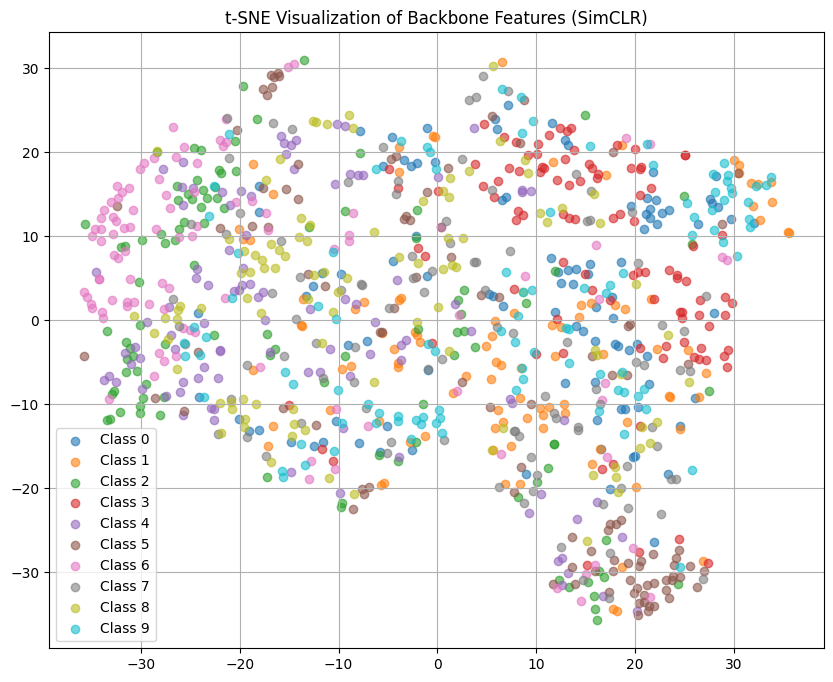

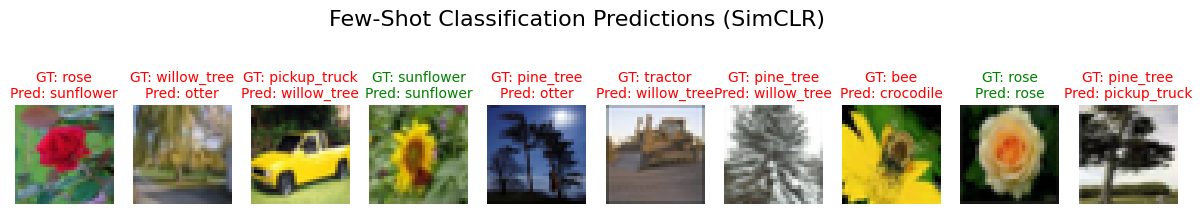

In [ ]:
def evaluate_simclr_backbone(model, cifar100, num_classes=10, k_shot=5, num_examples_to_plot=10, n_neighbors=1):
    """
    Evaluate the backbone (representation) learned via SimCLR on a few-shot classification task.

    Args:
        model (SimCLRModel): Trained SimCLR model.
        cifar100 (Dataset): CIFAR-100 dataset for few-shot evaluation.
        num_classes (int): Number of classes in the few-shot task.
        k_shot (int): Number of training examples per class.
        num_examples_to_plot (int): Number of test examples to display.
        n_neighbors (int): Number of neighbors for the k-NN classifier.

    Returns:
        float: The few-shot classification accuracy.
    """
    # Get the backbone from the SimCLR model
    backbone = model.backbone
    backbone.eval()

    # Reuse the previously defined few-shot data preparation function
    train_images, train_labels, test_images, test_labels, selected_classes = prepare_few_shot_data(cifar100, num_classes, k_shot)
    print(f"Few-shot task (SimCLR): {num_classes} classes, {k_shot}-shot")
    print(f"Training set: {len(train_images)} images, Test set: {len(test_images)} images")

    new_class_names = {i: cifar100.classes[selected_classes[i]] for i in range(num_classes)}
    print("Selected classes:", list(new_class_names.values()))

    random_baseline = 100.0 / num_classes
    print(f"Random baseline accuracy: {random_baseline:.2f}%")

    # Extract features from the backbone
    train_loader = DataLoader(TensorDataset(train_images, train_labels), batch_size=64, shuffle=False)
    test_loader = DataLoader(TensorDataset(test_images, test_labels), batch_size=64, shuffle=False)

    def extract_backbone_features(loader):
        features = []
        labels = []
        with torch.no_grad():
            for images, lbls in tqdm(loader, desc="Extracting Backbone Features"):
                images = images.to(device)
                emb = backbone(images)
                features.append(emb.cpu())
                labels.append(lbls)
        return torch.cat(features), torch.cat(labels)

    train_features, _ = extract_backbone_features(train_loader)
    test_features, _ = extract_backbone_features(test_loader)

    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(train_features.numpy(), train_labels.numpy())
    predictions = knn.predict(test_features.numpy())
    accuracy = np.mean(predictions == test_labels.numpy()) * 100
    print(f"{n_neighbors}-NN {k_shot}-shot accuracy (SimCLR): {accuracy:.2f}%")

    # t-SNE visualization of features
    tsne = TSNE(n_components=2, random_state=42)
    all_features = torch.cat([train_features, test_features], dim=0)
    all_labels = torch.cat([train_labels, test_labels], dim=0)
    embedded = tsne.fit_transform(all_features.numpy())

    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        mask = (all_labels == i).numpy()
        plt.scatter(embedded[mask, 0], embedded[mask, 1], alpha=0.6, label=f"Class {i}")
    plt.title('t-SNE Visualization of Backbone Features (SimCLR)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot a few test examples with predicted vs. ground-truth labels.
    num_examples_to_plot = min(num_examples_to_plot, len(test_images))
    indices = random.sample(range(len(test_images)), num_examples_to_plot)
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])

    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(indices):
        img = test_images[idx]
        img = img.cpu().numpy().transpose((1, 2, 0))
        img = std * img + mean
        img = np.clip(img, 0, 1)

        gt_label = test_labels[idx].item()
        pred_label = predictions[idx]
        gt_class = new_class_names[gt_label]
        pred_class = new_class_names[pred_label]
        title_color = 'green' if gt_label == pred_label else 'red'

        plt.subplot(1, num_examples_to_plot, i+1)
        plt.imshow(img)
        plt.title(f"GT: {gt_class}\nPred: {pred_class}", color=title_color, fontsize=10)
        plt.axis('off')
    plt.suptitle('Few-Shot Classification Predictions (SimCLR)', fontsize=16)
    plt.show()

    return accuracy

# Evaluate the SimCLR backbone on a few-shot classification task using CIFAR-100
simclr_few_shot_accuracy = evaluate_simclr_backbone(simclr_model, cifar100, num_classes=10, k_shot=5, num_examples_to_plot=10, n_neighbors=1)
